In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [3]:
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160113-01.mat'
# filename = fr'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/{session}.mat'
filename = fr'/om/user/eisenaj/ChaoticConsciousness/data/propofolPuffTone/{session}.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

# f = h5py.File(filename, 'r')
# airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 130.66 seconds)


## Load Results Function

In [7]:
def get_result_path(results_dir, session, window):
    regex = re.compile(f"VAR_{session}_window_{window}_stride_{window}")
    matching_files = []
    for file in os.listdir(results_dir):
        if regex.match(file):
            matching_files.append(file)
    
    # pick the most recent result, if there are multiple
    if len(matching_files) == 1:
        file = matching_files[0]
    else:
        file = None
        date = datetime(1996, 11, 8)
        for test_file in matching_files:
            test_date = datetime.strptime('_'.join(file.split('_')[-2:]), '%b-%d-%Y_%H%M')
            if test_date > date:
                file = test_file
                date = test_date
    
    return os.path.join(results_dir, file)

## Find Prediction Errors (All Window Sizes)

In [8]:
results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/VAR"
area = 'all'

predictions = {}
true_vals = {}
step_mse = {}
windows = [0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5]
for window in windows:
    print(f"Now computing window = {window}")
    result_path = get_result_path(results_dir, session, window)
    run_data = load(result_path)
    
    unit_indices = run_data['run_params']['unit_indices'][area]
    T_pred = 5
    predictions[window] = np.zeros((len(run_data['results'][area]), T_pred, len(unit_indices)))
    true_vals[window] = np.zeros(predictions[window].shape)

    for i in tqdm(range(predictions[window].shape[0])):
        row = run_data['results'][area].iloc[i]
        start_step = int(run_data['run_params']['stride']*i/dt)
        x0 = lfp[start_step + int(run_data['run_params']['window']/dt) - 1, unit_indices]

        for t in range(T_pred):
            if t == 0:
                predictions[window][i, t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
            else:
                predictions[window][i, t] = np.concatenate([[1], predictions[window][i, t - 1]]) @ row.A_mat_with_bias

        true_vals[window][i] = lfp[start_step + int(run_data['run_params']['window']/dt):start_step + int(run_data['run_params']['window']/dt) + T_pred, unit_indices]

    step_mse[window] = ((predictions[window] - true_vals[window])**2).mean(axis=2)

Now computing window = 0.5


  0%|          | 0/14110 [00:00<?, ?it/s]

Now computing window = 0.75


  0%|          | 0/9407 [00:00<?, ?it/s]

Now computing window = 1


  0%|          | 0/7055 [00:00<?, ?it/s]

Now computing window = 1.5


  0%|          | 0/4703 [00:00<?, ?it/s]

Now computing window = 2


  0%|          | 0/3527 [00:00<?, ?it/s]

Now computing window = 2.5


  0%|          | 0/2822 [00:00<?, ?it/s]

Now computing window = 3


  0%|          | 0/2351 [00:00<?, ?it/s]

Now computing window = 4


  0%|          | 0/1763 [00:00<?, ?it/s]

Now computing window = 5


  0%|          | 0/1411 [00:00<?, ?it/s]

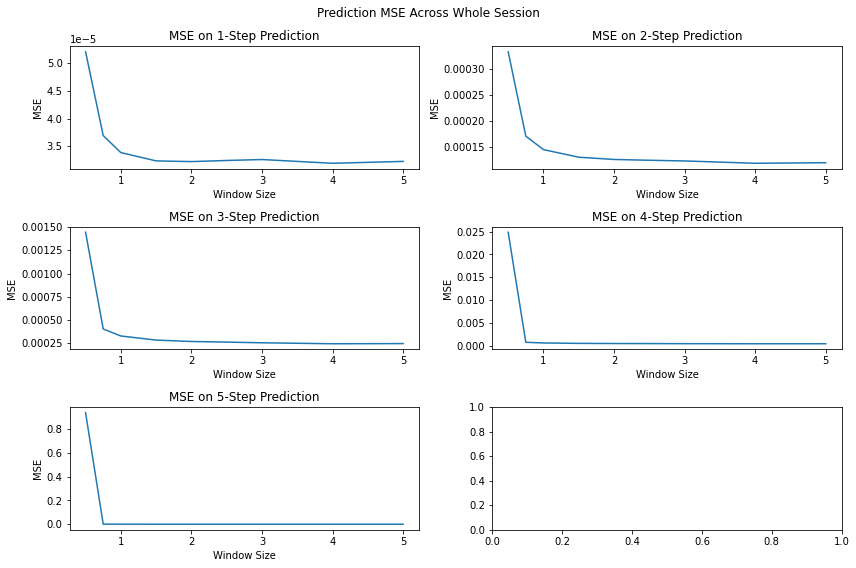

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i in range(5):
    ax = axs[int(i/2), i % 2]
    ax.plot(windows, [step_mse[window][1:, i].mean() for window in windows])
    ax.set_title(f"MSE on {i+1}-Step Prediction")
    ax.set_xlabel("Window Size")
    ax.set_ylabel("MSE")

plt.suptitle("Prediction MSE Across Whole Session")
plt.tight_layout()
plt.show()

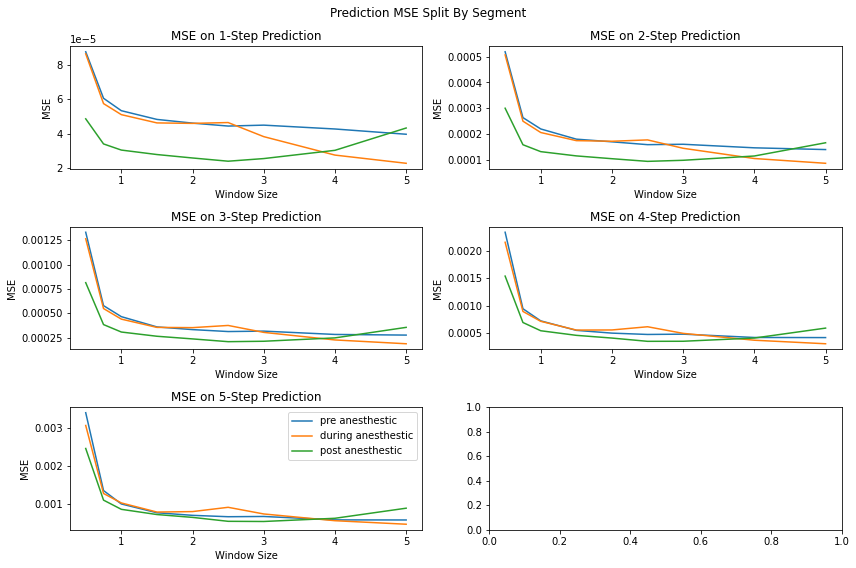

In [13]:
start_anesthesia = session_info['drugStart'][0]
start_anesthesia = int(start_anesthesia/run_data['run_params']['stride'])
end_anesthesia = session_info['drugEnd'][1]
end_anesthesia = int(end_anesthesia/run_data['run_params']['stride'])

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i in range(5):
    ax = axs[int(i/2), i % 2]
    ax.plot(windows, [step_mse[window][50:start_anesthesia, i].mean() for window in windows], label='pre anesthestic')
    ax.plot(windows, [step_mse[window][start_anesthesia:end_anesthesia, i].mean() for window in windows], label='during anesthestic')
    ax.plot(windows, [step_mse[window][end_anesthesia:, i].mean() for window in windows], label='post anesthestic')
    ax.set_title(f"MSE on {i+1}-Step Prediction")
    ax.set_xlabel("Window Size")
    ax.set_ylabel("MSE")

ax.legend()
plt.suptitle("Prediction MSE Split By Segment")
plt.tight_layout()
plt.show()

## Find Prediction Errors (One Window Size)

In [48]:
window = 0.15
results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/VAR"
run_data = get_result(results_dir, session, window)

In [76]:
area = 'all'

unit_indices = run_data['run_params']['unit_indices'][area]
T_pred = 5
predictions = np.zeros((len(run_data['results'][area]), T_pred, len(unit_indices)))
true_vals = np.zeros(predictions.shape)

for i in tqdm(range(predictions.shape[0])):
    row = run_data['results'][area].iloc[i]
    start_step = int(run_data['run_params']['stride']*i/dt)
    x0 = lfp[start_step + int(run_data['run_params']['window']/dt) - 1, unit_indices]

    for t in range(T_pred):
        if t == 0:
            predictions[i, t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
        else:
            predictions[i, t] = np.concatenate([[1], predictions[i, t - 1]]) @ row.A_mat_with_bias
            
    true_vals[i] = lfp[start_step + int(run_data['run_params']['window']/dt):start_step + int(run_data['run_params']['window']/dt) + T_pred, unit_indices]

step_mse = ((predictions - true_vals)**2).mean(axis=2)

  0%|          | 0/47035 [00:00<?, ?it/s]

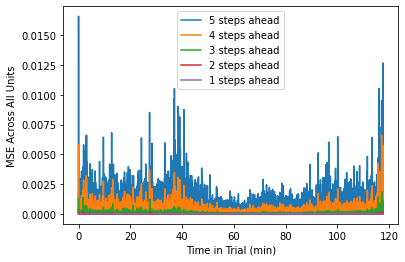

In [103]:
# i = 90
# unit_num = 5
# plt.plot(predictions[i, :, unit_num])
# plt.plot(true_vals[i, :, unit_num])
# plt.show()

time_in_trial = np.arange(step_mse.shape[0])*run_data['run_params']['stride']/60
for t in range(4, -1, -1):
    plt.plot(time_in_trial[1:], step_mse[1:, t], label=f"{t + 1} steps ahead")
plt.legend()
plt.xlabel("Time in Trial (min)")
plt.ylabel("MSE Across All Units")
plt.show()